# add bench to valid 2 (really, just testing two more stuffs)

In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer
import umap

from grnndata import GRNAnnData, read_h5ad, from_anndata
from grnndata import utils 
from bengrn import BenGRN, get_sroy_gt


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter

from bengrn.base import get_GT_db

from scprint.utils import utils

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

from bengrn.base import train_classifier
from scib_metrics.benchmark import Benchmarker

from scprint.tasks import Embedder
from bengrn import compute_genie3, compute_scenic

from joblib import dump, load
from bengrn.base import compute_pr
from grnndata import utils as grnutils

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
2024-04-19 18:04:42,793:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-04-19 18:04:42,886:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-04-19 18:04:42,976:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-04-19 18:04:43,063:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-04-19 18:04:43,156:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-04-19 18:04:43,331:INFO - Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/arboreto/core.py:12: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask D

In [2]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt', precpt_gene_emb = '../../data/main/gene_embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
res = {}

In [4]:
preadata = get_sroy_gt(get="chen", species="human")
adata = preprocessor(preadata.copy())

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


In [15]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=6000,
    max_cells=128,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:200,0:1}, max_iter=4_000, train_size=0.4, return_full=False)

/tmp/ipykernel_569772/3952859958.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


number of expressed genes in this cell type: 7906


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 128 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
couldn't log to tensorboard
couldn't log to wandb


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


pred shape (8, 2532, 96)
true elem 449 ...


ValueError: Found input variables with inconsistent numbers of samples: [20256, 19848]

## just testing if we can make predictions per regulon

In [19]:
sub.sum(1)

POU5F1    349.0
PRDM14     46.0
REST        6.0
SALL4      28.0
STAT3       6.0
ZFP42       3.0
ZIC3        1.0
ZNF281     10.0
dtype: float64

In [30]:
from anndata.utils import make_index_unique
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))

In [31]:
elems = preadata.var[preadata.grn.sum(1) != 0].index.tolist()
sub = preadata.get(grn.var["symbol"].tolist()).get(elems).targets

genes = grn.var["symbol"].tolist()
args = np.argsort(genes)


In [32]:
genes = np.array(genes)[args]
adj = grn.varp["GRN"][args, :, :][:, args, :][np.isin(genes, sub.index.values)][
    :, np.isin(genes, sub.columns.values)
]
print("pred shape", adj.shape)
da = sub.values

pred shape (8, 2481, 96)
 (8, 2481, 96)


In [33]:
sub.shape

(8, 2481)

In [34]:
print("true elem", int(da.sum()), "...")
da = da.flatten()
adj = adj.reshape(-1, adj.shape[-1])

true elem 449 ...


NameError: name 'train_size' is not defined

doing regression....


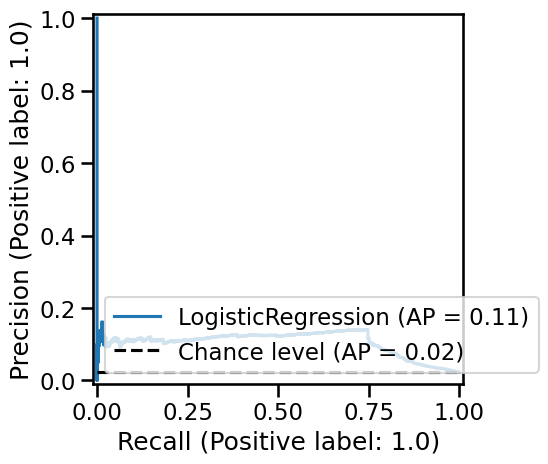

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    adj, da, random_state=0, train_size=0.3
)
print("doing regression....")
clf = LogisticRegression(
    penalty="l1",
    C=0.4,
    solver="liblinear",
    class_weight={1:100,0:1},
    max_iter=4_000,
    n_jobs=8,
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
metrics = {
    "used_heads": (clf.coef_ != 0).sum(),
    "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),
    "random_precision": y_test.sum() / len(y_test),
    "recall": (pred[y_test == 1] == 1).sum() / y_test.sum(),
    "random_recall": pred.sum() / len(pred),
    "predicted_true": pred.sum(),
    "number_of_true": y_test.sum(),
}
PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, plot_chance_level=True
)
plt.show()

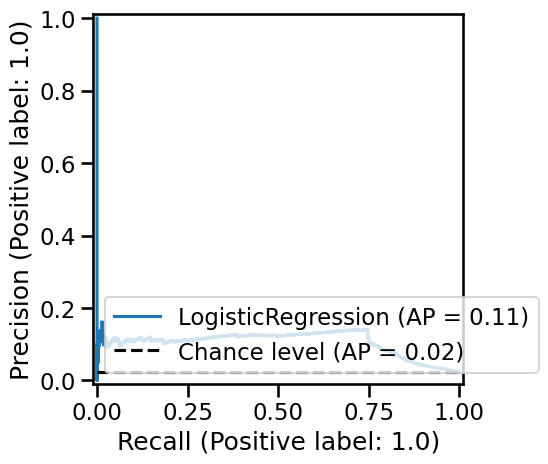

In [65]:
clf = LogisticRegression(
    penalty="l1",
    C=0.4,
    solver="liblinear",
    class_weight={1:200,0:1},
    max_iter=4_000,
    n_jobs=8,
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
metrics = {
    "used_heads": (clf.coef_ != 0).sum(),
    "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),
    "random_precision": y_test.sum() / len(y_test),
    "recall": (pred[y_test == 1] == 1).sum() / y_test.sum(),
    "random_recall": pred.sum() / len(pred),
    "predicted_true": pred.sum(),
    "number_of_true": y_test.sum(),
}
PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, plot_chance_level=True
)
plt.show()

In [66]:
metrics

{'used_heads': 2,
 'precision': 0.03317535545023697,
 'random_precision': 0.022815603857780337,
 'recall': 0.9495268138801262,
 'random_recall': 0.6530156902259968,
 'predicted_true': 9073.0,
 'number_of_true': 317.0}

In [68]:
grn.var[grn.var["symbol"]=="POU5F1"]

,uid,symbol,ncbi_gene_ids,biotype,description,synonyms,organism_id,public_source_id,created_by_id,mt,ribo,hb,organism,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,TFs
ENSG00000229094,5uym5gFaktN7,POU5F1,5460,protein_coding,POU class 5 homeobox 1 [Source:HGNC Symbol;Acc...,OCT4|OCT3/4|OCT3|OCT-4|MGC22487|OTF3,2,9.0,1,False,False,False,NCBITaxon:9606,0,0.0,0.0,100.0,0.0,0.0,True


In [ ]:
clf.predict(

In [ ]:
clf.

In [76]:
clf.predict(grn.varp["GRN"][grn.var["symbol"]=="STAT3",:].reshape(-1, grn.varp["GRN"].shape[-1]))

array([0., 1., 0., ..., 0., 0., 0.])

In [80]:
grn.var.loc[clf.predict(grn.varp["GRN"][grn.var["symbol"]=="STAT3",:].reshape(-1, grn.varp["GRN"].shape[-1])).astype(bool)]['symbol'].tolist()

ValueError: Found array with 0 sample(s) (shape=(0, 96)) while a minimum of 1 is required by LogisticRegression.

In [83]:
grn_inferer = GRNfer(model, adata,
    how="random expr",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=2000,
    max_cells=64,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:200,0:1}, max_iter=4_000, train_size=0.4, return_full=False)

/tmp/ipykernel_569772/2315311075.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
from anndata.utils import make_index_unique
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))

In [ ]:
elems = preadata.var[preadata.grn.sum(1) != 0].index.tolist()
sub = preadata.get(grn.var["symbol"].tolist()).get(elems).targets

genes = grn.var["symbol"].tolist()
args = np.argsort(genes)


In [ ]:
genes = np.array(genes)[args]
adj = grn.varp["GRN"][args, :, :][:, args, :][np.isin(genes, sub.index.values)][
    :, np.isin(genes, sub.columns.values)
]
print("pred shape", adj.shape)
da = sub.values

pred shape (8, 2481, 96)


In [ ]:
205_865_362_944

In [ ]:
sub.shape

(8, 2481)

In [ ]:
print("true elem", int(da.sum()), "...")
da = da.flatten()
adj = adj.reshape(-1, adj.shape[-1])

true elem 449 ...


NameError: name 'train_size' is not defined

doing regression....


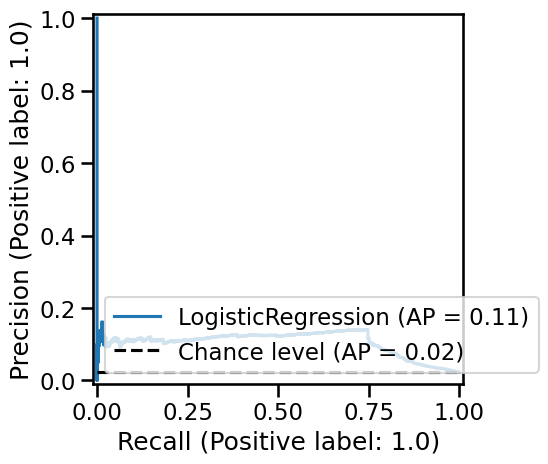

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    adj, da, random_state=0, train_size=0.3
)
print("doing regression....")
clf = LogisticRegression(
    penalty="l1",
    C=0.4,
    solver="liblinear",
    class_weight={1:100,0:1},
    max_iter=4_000,
    n_jobs=8,
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
metrics = {
    "used_heads": (clf.coef_ != 0).sum(),
    "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),
    "random_precision": y_test.sum() / len(y_test),
    "recall": (pred[y_test == 1] == 1).sum() / y_test.sum(),
    "random_recall": pred.sum() / len(pred),
    "predicted_true": pred.sum(),
    "number_of_true": y_test.sum(),
}
PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, plot_chance_level=True
)
plt.show()

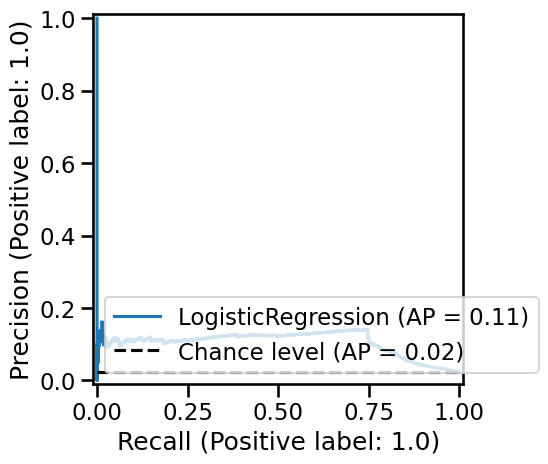

In [ ]:
clf = LogisticRegression(
    penalty="l1",
    C=0.4,
    solver="liblinear",
    class_weight={1:200,0:1},
    max_iter=4_000,
    n_jobs=8,
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
metrics = {
    "used_heads": (clf.coef_ != 0).sum(),
    "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),
    "random_precision": y_test.sum() / len(y_test),
    "recall": (pred[y_test == 1] == 1).sum() / y_test.sum(),
    "random_recall": pred.sum() / len(pred),
    "predicted_true": pred.sum(),
    "number_of_true": y_test.sum(),
}
PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, plot_chance_level=True
)
plt.show()

In [ ]:
metrics

{'used_heads': 2,
 'precision': 0.03317535545023697,
 'random_precision': 0.022815603857780337,
 'recall': 0.9495268138801262,
 'random_recall': 0.6530156902259968,
 'predicted_true': 9073.0,
 'number_of_true': 317.0}

In [ ]:
grn.var[grn.var["symbol"]=="POU5F1"]

,uid,symbol,ncbi_gene_ids,biotype,description,synonyms,organism_id,public_source_id,created_by_id,mt,ribo,hb,organism,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,TFs
ENSG00000229094,5uym5gFaktN7,POU5F1,5460,protein_coding,POU class 5 homeobox 1 [Source:HGNC Symbol;Acc...,OCT4|OCT3/4|OCT3|OCT-4|MGC22487|OTF3,2,9.0,1,False,False,False,NCBITaxon:9606,0,0.0,0.0,100.0,0.0,0.0,True


In [ ]:
clf.predict(

In [ ]:
clf.

In [ ]:
clf.predict(grn.varp["GRN"][grn.var["symbol"]=="STAT3",:].reshape(-1, grn.varp["GRN"].shape[-1]))

array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:
grn.var.loc[clf.predict(grn.varp["GRN"][grn.var["symbol"]=="STAT3",:].reshape(-1, grn.varp["GRN"].shape[-1])).astype(bool)]['symbol'].tolist()

ValueError: Found array with 0 sample(s) (shape=(0, 96)) while a minimum of 1 is required by LogisticRegression.